In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import random
from pathlib import Path

Definitions:
- $W_i$ is the number of votes for the winning party in unit $i$.
- $N_i$ is the number of registered voters in unit $i$.
- $V_i$ is the number of valid votes in unit $i$.

# Cleaning steps
- Remove N/A rows
- Remove units where $W_i = 0$
- Remove units where $W_i > N_i$ 
- Remove units where $N_i < 100$
- Remove units in region `"OAV"`

In [2]:
def clean(df):
    df = df.dropna(thresh=2)
    df = df[df["votes_bbm"] > 0]
    df = df[df["votes_bbm"] <= df["registered_voters"]]
    df = df[df["registered_voters"] >= 100]
    df = df[df["reg_name"] != "OAV"]
    return df

In [4]:
# Load all CSVs in folder
path_data_root = Path("./datasets")
paths_csv = filter(lambda x : x.suffix == ".csv", path_data_root.iterdir())
# store all datasets in dictionary (filename -> dataframe)
dataframes = {path.stem : clean(pd.read_csv(path)) for path in paths_csv}
dataframes.keys()

dict_keys(['model_dummy_brg'])

# Plot fingerprint

The 2D vote turnout distribution (vtd) for the winning candidate, or fingerprint, is a 2D histogram, for a given fraction of voter turnout $\dfrac{V_i}{N_i}$ ($x$ axis) and the percentage of votes for the winning party $\dfrac{W_i}{V_i}$ ($y$ axis). These are plotted in $[0,1] \times [0,1]$.

In [10]:
def plot_fingerprint(df, image_filename, **kwargs):
    if "title" in kwargs:
        title = kwargs["title"]
    else:
        title = image_filename
        
    df["voter_turnout_ratio"] = df["total_votes"] / df["registered_voters"] * 100
    df["votes_for_winner_ratio"] = df["votes_bbm"] / df["total_votes"] * 100
    
    sns.set(rc={})    
    plt = sns.JointGrid(data=df, 
                        x="voter_turnout_ratio", 
                        y="votes_for_winner_ratio", 
                        xlim = (0,100), ylim = (0,100)).set_axis_labels(
            "voter turnout ratio (%)",
            "votes for winner ratio (%)"
        )
    
    plt.plot_joint(sns.histplot, kde=True)
    plt.plot_marginals(sns.histplot, kde=True)
    
    plt.figure.suptitle(title, y = 0)
    Path("./results-fingerprint").mkdir(exist_ok=True)
    plt.savefig(f"./results-fingerprint/{image_filename}.png")
    return None

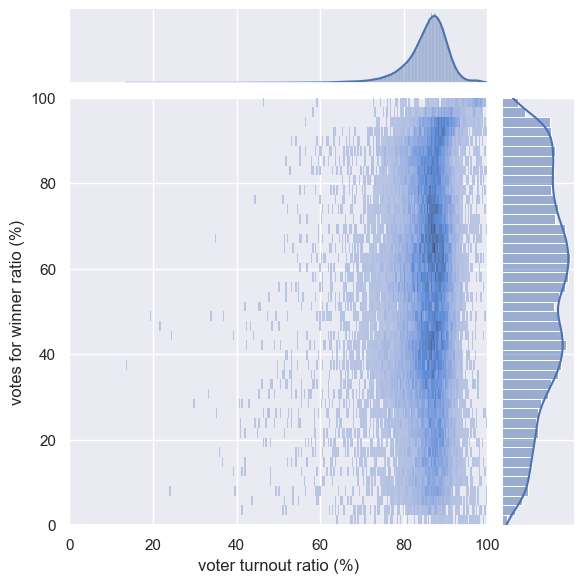

In [11]:
for key, df in dataframes.items():
    plot_fingerprint(df, key, title="")

# Compute log vote rate
- The **logarithmic vote rate** is a random variable defined by
$$v_i = \ln \dfrac{N_i - W_i}{W_i}$$
- Here, we plot the scaled logarithmic vote rate (the $v_i$s are standardized) alongside $\mathcal{N}(0,1)$ for each aggregation level

In [15]:
def plot_log_vote_rate(df, image_filename):
    log_vote_rate = np.log( (df["registered_voters"] - df["votes_bbm"]) / df["votes_bbm"])
    mean = scipy.stats.describe(log_vote_rate).mean
    variance = scipy.stats.describe(log_vote_rate).variance
    
    
    log_vote_rate = (log_vote_rate - mean) / np.sqrt(variance)
    
    sns.set(rc={})
    # print("---")
    # print(f"{image_filename} statistics of log vote rate")
    # print(f"mean: {mean}")
    # print(f"variance: {variance}")
    # print(f"skewness: {scipy.stats.skew(df['log_vote_rate'])}")
    # print(f"kurtosis: {scipy.stats.kurtosis(df['log_vote_rate'])}")
    # print("---")
    plt = sns.displot(log_vote_rate, kde=True, stat="density", binwidth=0.1)
    
    # plot standard normal
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf, 0, 1)
    plt.ax.plot(x_pdf, y_pdf, "black", lw=2)
    plt.set(title = f"{image_filename}", xlim=(-4,4), ylim=(0,1))
    Path("./results-logvoterate").mkdir(exist_ok=True)
    plt.savefig(f"./results-logvoterate/logvoterate_{image_filename}")
    return None

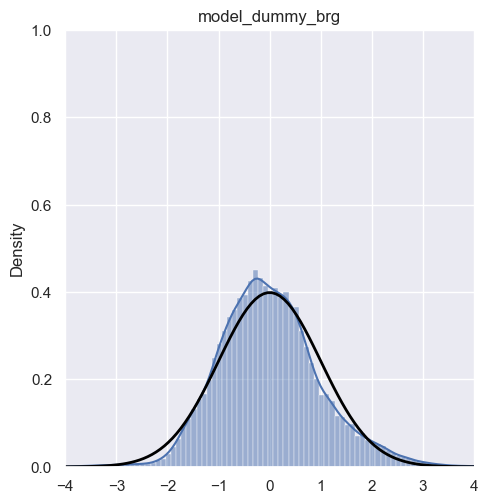

In [17]:
for key, df in dataframes.items():
    plot_log_vote_rate(df, key)